In [329]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt


import numpy as np
import pandas as pd
from datetime import datetime
import datetime as dt

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
#List table columns
print(f"Measurement table columns: {[column.key for column in Measurement.__table__.columns]}")
print(f"Station table columns: {[column.key for column in Station.__table__.columns]}")

Measurement table columns: ['id', 'station', 'date', 'prcp', 'tobs']
Station table columns: ['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# from sqlalchemy import desc

# Exploratory Climate Analysis

In [182]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Find date of lastest measurement in Measurement table and covert to date object
last_date_result = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = datetime.strptime(last_date_result[0], '%Y-%m-%d').date()

# Calculate the date 1 year ago from the last data point in the database
from dateutil.relativedelta import relativedelta

first_date = last_date.replace(year=last_date.year - 1)
first_date = last_date - relativedelta(years=1)

# Perform a query to retrieve the data and precipitation scores
query_result = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date.between(first_date, last_date)).\
        order_by(Measurement.date.desc()).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
df_precip = pd.DataFrame(query_result)
df_precip.set_index("date", inplace = True) 

# Sort the dataframe by date
df_precip.sort_values("date", ascending=True, inplace=True)

df_precip.head()

,prcp
date,
2016-08-23,0.70
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,1.79
2016-08-23,NaN


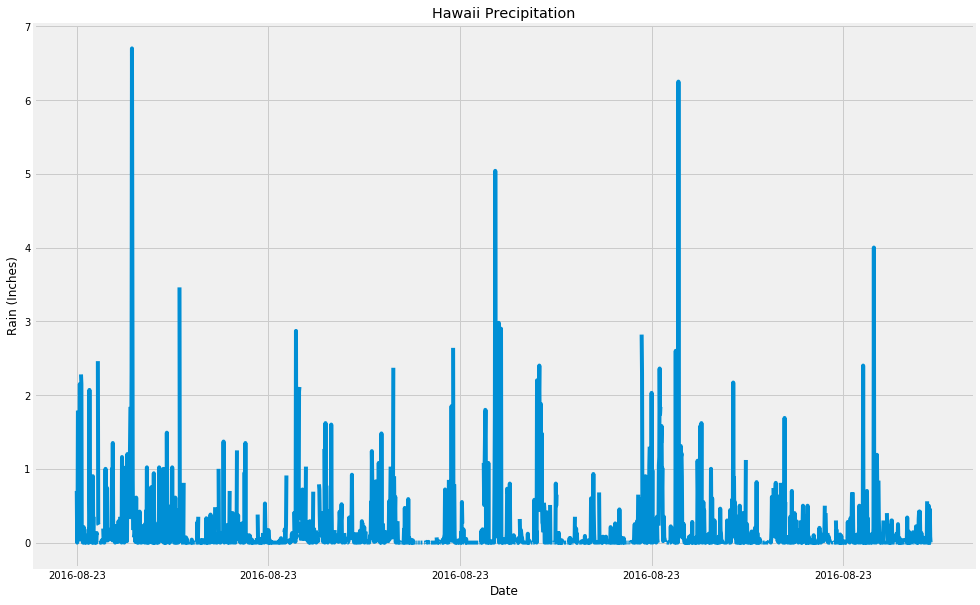

In [72]:
# Use Pandas Plotting with Matplotlib to plot the data

ax = df_precip.plot( figsize=(15, 10), legend=False, title ="Hawaii Precipitation")

ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Rain (Inches)", fontsize = 12)



###########################################
####COME BACK TO
# ax.set_xlim([first_date, last_date])
# ax.set_xticklabels(df_precip.index)
# ax.set_xticklabels(df_precip['date'])
#ax.xaxis.set_ticks(df_precip.index)



plt.show()

In [427]:
# Use Pandas to calcualte the summary statistics for the precipitation data

df_precip.describe()


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [120]:
# Design a query to show how many stations are available in this dataset?
session.query(Station).distinct(Station.id).count()

9

In [185]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [270]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.station == "USC00519281").all()



[(54.0, 85.0, 71.66378066378067)]

USC00519281


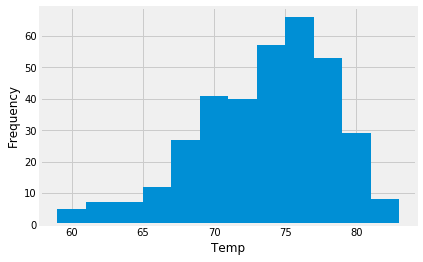

In [257]:
# Choose the station with the highest number of temperature observations.
print(session.query(Measurement.station, func.count(Measurement.tobs)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.tobs).desc()).first()[0])


# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query_result = session.query(Measurement.tobs).\
        filter(Measurement.date.between(first_date, last_date)).\
        filter(Measurement.station == "USC00519281").all()

temp_data_df = pd.DataFrame(query_result)

ax = temp_data.plot(kind='hist', bins = 12, legend = False)

ax.set_xlabel("Temp", fontsize=12)

plt.show()


In [468]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example

trip_start = datetime.strptime("2017-05-18", '%Y-%m-%d').date()

trip_end =  datetime.strptime("2017-05-30", '%Y-%m-%d').date()


calc_temps(trip_start, trip_end)


[(68.0, 74.83561643835617, 87.0)]

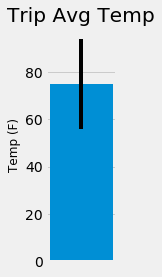

In [467]:
fig, ax = plt.subplots()

ax.bar(0, query_result[0][1], yerr = (query_result[0][2] - query_result[0][0]), align='center' )
ax.set_xticks([])
ax.set_ylabel("Temp (F)", fontsize=12)
ax.set_title("Trip Avg Temp")

ax.set_aspect(.03)
plt.show()


In [428]:
print(f"Measurement table columns: {[column.key for column in Measurement.__table__.columns]}")
print(f"Station table columns: {[column.key for column in Station.__table__.columns]}")

Measurement table columns: ['id', 'station', 'date', 'prcp', 'tobs']
Station table columns: ['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [472]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(Station.station, Station.name, Station.latitude, \
              Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
                join(Measurement, Measurement.station == Station.station).\
                group_by(Station.station).\
                filter(Measurement.date.between(trip_start, trip_end)).\
                order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  4.29),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  2.39),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  1.7300000000000002),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.61),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.66),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.52)]

In [481]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
# Create a list of dates trip 
datelist = pd.date_range(trip_start, periods=13).tolist()

# Calculate daily norms for each day and append to a list
norm_list = []
for date in datelist:
    norm_list.append(daily_normals(date.strftime("%m-%d")))
print(norm_list)

[[(68.0, 74.10714285714286, 82.0)], [(65.0, 73.80701754385964, 79.0)], [(68.0, 73.89655172413794, 79.0)], [(64.0, 72.96428571428571, 80.0)], [(64.0, 74.45614035087719, 80.0)], [(68.0, 74.94827586206897, 87.0)], [(67.0, 73.94827586206897, 79.0)], [(68.0, 74.27586206896552, 79.0)], [(65.0, 74.03636363636363, 82.0)], [(65.0, 74.49090909090908, 80.0)], [(67.0, 74.27777777777777, 82.0)], [(64.0, 74.19607843137256, 80.0)], [(69.0, 74.33333333333333, 81.0)]]


In [461]:
datelist = pd.date_range((datetime.strptime('2017-05-18', '%Y-%m-%d')), periods=13).tolist()

# type(datetime.strptime('2017-05-18', '%Y-%m-%d'))
datelist
# pd.date_range(start='1/1/2018', end='1/08/2018')

for date in datelist:
    print (date.strftime("%d-%m"))



18-05
19-05
20-05
21-05
22-05
23-05
24-05
25-05
26-05
27-05
28-05
29-05
30-05


In [274]:


end_date = [row.date for row in session.query(Measurement.date).order_by((Measurement.date).desc()).limit(1)][0]
# print(max_date)

# type(session.query(Measurement.date).filter((Measurement.id ==1)).limit(1))

# type(dt.datetime(end_date))

first_row = session.query(Measurement.date, func.max(Measurement.date))



[column.key for column in Measurement.__table__.columns]

first_entry = session.query(Measurement)  #.get(1)

# for entry in first_entry:
#     print(type(entry))


    
# print(first_entry.__str__)
# type(first_entry)
# for i in first_entry:
#     print(i.id)

first_entry.column_descriptions
print(end_date)

2017-08-23
